# Домашняя работа № 2

1. *Создать код на Python, который разделит ваши данные на тренировочный, тестовый и валидационный наборы данных.*
2. *Построить одну или несколько моделей на основе паттернов технического анализа, которая будет принимать торговые решения по бумагам SnP500 и/или криптовалютам.*
3. *Провести подбор гиперпараметров моделей с использованием обучающей и тестовой выборок.*
4. *Провести финальное тестирование построенных торговых стратегий на валидационном наборе данных и сравнить их между собой.*
5. *Сформировать дашборд, показывающий эффективность различных стратегий во времени.*

In [1]:
#Подключаем библиотеки

import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from scipy import stats
import plotly.express as px
import talib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import train_test_split
from datetime import date, datetime, timedelta
from plotly.subplots import make_subplots
from backtesting import Backtest, Strategy

C:\Users\zarocool\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Загружаем данные
data = pd.read_csv('Investing_data.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume,tic
0,2019-01-02,39.480000,39.712502,38.557499,38.722500,148158800,AAPL
1,2019-01-03,35.547501,36.430000,35.500000,35.994999,365248800,AAPL
2,2019-01-04,37.064999,37.137501,35.950001,36.132500,234428400,AAPL
3,2019-01-07,36.982498,37.207500,36.474998,37.174999,219111200,AAPL
4,2019-01-08,37.687500,37.955002,37.130001,37.389999,164101200,AAPL
...,...,...,...,...,...,...,...
7815,2025-03-17,119.529999,122.889999,118.029999,122.739998,255501500,NVDA
7816,2025-03-18,115.430000,119.019997,114.540001,118.000000,299686900,NVDA
7817,2025-03-19,117.519997,120.449997,115.680000,117.269997,273426200,NVDA
7818,2025-03-20,118.529999,120.199997,116.470001,116.550003,248829700,NVDA


In [4]:
df = pd.DataFrame()

In [5]:
#Добавим индикаторы
for i in data["tic"].unique():
    data_temp = data.loc[data['tic'] == i]
    data_temp.loc[:,['sma_5']] = talib.SMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,['sma_10']] = talib.SMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,['sma_15']] = talib.SMA(data_temp["Close"], timeperiod=15)
    data_temp.loc[:,['sma_20']] = talib.SMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,['sma_50']] = talib.SMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,['sma_200']] = talib.SMA(data_temp["Close"], timeperiod=200)
    data_temp.loc[:,['sma_ratio_5_15']] = data_temp['sma_15'] / data_temp['sma_5']
    data_temp.loc[:,['sma_ratio_10_50']] = data_temp['sma_50'] / data_temp['sma_15']
    data_temp.loc[:,['sma_5_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=5)
    data_temp.loc[:,['sma_10_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=10)
    data_temp.loc[:,['sma_15_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=15)
    data_temp.loc[:,['sma_50_Volume']] = talib.SMA(data_temp["Volume"], timeperiod=50)
    data_temp.loc[:,["sma_Volume_ratio_5_15"]] = data_temp['sma_5_Volume'] / data_temp['sma_15_Volume']
    data_temp.loc[:,["sma_Volume_ratio_10_50"]] = data_temp['sma_10_Volume'] / data_temp['sma_50_Volume']
    data_temp.loc[:,["ema_5"]] = talib.EMA(data_temp["Close"], timeperiod=5)
    data_temp.loc[:,["ema_10"]] = talib.EMA(data_temp["Close"], timeperiod=10)
    data_temp.loc[:,["ema_20"]] = talib.EMA(data_temp["Close"], timeperiod=20)
    data_temp.loc[:,["ema_50"]] = talib.EMA(data_temp["Close"], timeperiod=50)
    data_temp.loc[:,["ema_200"]] = talib.EMA(data_temp["Close"], timeperiod=200)
    
    # Calculate the Bollinger Bands
    data_temp.loc[:,["upper_band"]], data_temp.loc[:,["middle_band"]], data_temp.loc[:,["lower_band"]] = talib.BBANDS(data_temp["Close"], timeperiod=20)
    
    # Calculate the relative strength index (RSI)
    data_temp.loc[:,["RSI"]] = talib.RSI(data_temp["Close"], timeperiod=14)
    
    # Calculate the MACD
    data_temp.loc[:,["macd"]], data_temp.loc[:,["macd_signal"]], data_temp.loc[:,["macd_hist"]] = talib.MACD(data_temp["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    
    data_temp.loc[:,['ADX_5']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['ADX_15']] = talib.ADX(data_temp['High'], data_temp['Low'], data_temp['Close'], timeperiod=15)
    
    data_temp.loc[:,['RSI_5']] = talib.RSI(data_temp['Close'], timeperiod=5)
    data_temp.loc[:,['RSI_15']] = talib.RSI(data_temp['Close'], timeperiod=15)
    data_temp.loc[:,['RSI_ratio']] = data_temp['RSI_5']/data_temp['RSI_15']
    
    data_temp.loc[:,['ROC']] = talib.ROC(data_temp['Close'], timeperiod=15)

    data_temp.loc[:,['HAMMER']] = talib.CDLHAMMER(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['SHOOTING_STAR']] = talib.CDLSHOOTINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['ENGULFING']] = talib.CDLENGULFING(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MORNING_STAR']] = talib.CDLMORNINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['EVENING_STAR']] = talib.CDLEVENINGSTAR(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['MARUBOZU']] = talib.CDLMARUBOZU(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    data_temp.loc[:,['DOJI']] = talib.CDLDOJI(data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'])
    #Определим, что значение таргета это рост завтрашней цены относительно текущей, с учетом комиссии в 1$
    data_temp.loc[:,['target']] = np.where(-data_temp['Close'].diff(periods=-1) > 1, True, False)
    data_temp.loc[:,['diff']] = -data_temp['Close'].diff(periods=-1)
    data_temp.dropna(inplace=True)
    df = pd.concat([df, data_temp], ignore_index=True)

C:\Users\zarocool\AppData\Local\Temp\ipykernel_14396\2038821334.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=True)
C:\Users\zarocool\AppData\Local\Temp\ipykernel_14396\2038821334.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=True)
C:\Users\zarocool\AppData\Local\Temp\ipykernel_14396\2038821334.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp.dropna(inplace=T

In [6]:
#Определим признаки, с которорыми будет работать модель
features = ['sma_5', 'sma_10', 'sma_15', 'sma_50', 'sma_200', 'sma_ratio_5_15', 'sma_ratio_10_50', 
            'sma_5_Volume', 'sma_10_Volume', 'sma_15_Volume', 'sma_50_Volume', 'sma_Volume_ratio_5_15', 'sma_Volume_ratio_10_50', 'upper_band',
            'middle_band', 'lower_band', 'RSI', 'macd', 'macd_signal', 'macd_hist',
            'ADX_5', 'ADX_15', 'RSI_5', 'RSI_15', 'RSI_ratio', 'ROC','HAMMER','SHOOTING_STAR','ENGULFING','MORNING_STAR','EVENING_STAR','MARUBOZU','DOJI']

In [7]:
df.dropna(inplace=True)
df = df.sort_values(by = ['Date','tic'],ascending = True, ignore_index = True)
df["target"] = df["target"].astype(bool)

In [8]:
#Разделим данные на три части: обучающую выборку, валидационную и тестовую
def split(df):
    train_value = int(len(df) * 0.7)
    val_value = int(len(df) * 0.15)
    test_value = int(len(df) * 0.15)
    train_df = df.iloc[:train_value]
    val_df = df.iloc[train_value:(train_value+val_value)]
    test_df = df.iloc[(val_value+train_value):]
    
    X_train, X_val, X_test = train_df[features], val_df[features], test_df[features]
    y_train, y_val, y_test = train_df["target"], val_df["target"], test_df["target"]
    return X_train,y_train,X_val,y_val,X_test,y_test, val_value+train_value
X_train,y_train,X_val,y_val,X_test,y_test, len_tr_val = split(df)

In [9]:
df.tic.unique()

array(['AAPL', 'GOOGL', 'META', 'MSFT', 'NVDA'], dtype=object)

## Создание функции по перебору параметров и нахождения лучшей модели на валидационной выборке

Можно использовать GridsearchCV с кроссвалидацией, но поскольку в ДЗ нужно открыто показать валидацию, я сделала функцию для оценки параметров на валидационной выборке.

In [10]:
# Буду работать с двумя моделями 'GradientBoosting' или 'CatBoost'
# Функция будет возвращать лучшие параметры
# На лучших параметрах обучим модели с объединением трейновой и валидационной выборок

from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

def best_param_class(X_train, y_train, X_val, y_val, model_type, param_grid):
    #Начальное значение best_score будет -1
    best_score = -1
    best_params = None
    
    # Генерация всех комбинаций параметров
    from itertools import product
    param_combinations = list(product(*param_grid.values()))
    
    for params in param_combinations:
        current_params = dict(zip(param_grid.keys(), params))
        
        # Выбор и обучение модели
        if model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(**current_params, random_state=42, verbose=0)
        elif model_type == 'catboost':
            model = CatBoostClassifier(**current_params, random_state=42, verbose=0)
        else:
            raise ValueError("Неизвестный тип модели. Используй 'gradient_boosting' или 'catboost'.")
            
        model.fit(X_train, y_train)
        
        # Предсказание и оценка
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='weighted')
        
        # Обновление лучших параметров
        if score > best_score:
            best_score = score
            best_params = current_params
    
    return best_params, best_score

# Задаём параметры для перебора GradientBoosting

param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Задаём параметры для перебора CatBoost
param_grid_cb = {
    'iterations': [50, 100, 150],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Поиск для GradientBoosting
best_params_gb, best_score_gb = best_param_class(
    X_train, y_train, X_val, y_val, 'gradient_boosting', param_grid_gb
)
print(f"Лучшие параметры для GradientBoosting: {best_params_gb}, F1-score: {best_score_gb:.4f}")

# Поиск для CatBoost
best_params_cb, best_score_cb = best_param_class(
    X_train, y_train, X_val, y_val, 'catboost', param_grid_cb
)
print(f"Лучшие параметры для CatBoost: {best_params_cb}, F1-score: {best_score_cb:.4f}")

# Обучение финальной модели на объединённых данных
X_final = np.vstack([X_train, X_val])
y_final = np.concatenate([y_train, y_val])

final_model_gb = GradientBoostingClassifier(**best_params_gb, random_state=42)
final_model_gb.fit(X_final, y_final)

final_model_cb = CatBoostClassifier(**best_params_cb, random_state=42, verbose=0)
final_model_cb.fit(X_final, y_final)

Лучшие параметры для GradientBoosting: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}, F1-score: 0.5572
Лучшие параметры для CatBoost: {'iterations': 150, 'depth': 5, 'learning_rate': 0.2}, F1-score: 0.5562


In [11]:
GradientBoosting_roc_auc_score = roc_auc_score(y_test, final_model_gb.predict_proba(X_test)[:, 1])
GradientBoosting_f1_score = f1_score(y_test, final_model_gb.predict(X_test))
GradientBoosting_accuracy = accuracy_score(y_test, final_model_gb.predict(X_test))
GradientBoosting_precision = precision_score(y_test, final_model_gb.predict(X_test))
GradientBoosting_recall = recall_score(y_test, final_model_gb.predict(X_test))

CatBoost_roc_auc_score = roc_auc_score(y_test, final_model_cb.predict_proba(X_test)[:, 1])
CatBoost_f1_score = f1_score(y_test, final_model_cb.predict(X_test))
CatBoost_accuracy = accuracy_score(y_test, final_model_cb.predict(X_test))
CatBoost_precision = precision_score(y_test, final_model_cb.predict(X_test))
CatBoost_recall = recall_score(y_test, final_model_cb.predict(X_test))

print('Total score\t\t\tROC_AUC\t\tF1\tAccuracy\tPrecision\tRecall')
print('\t\t\t\t\t\t\t\t\t(Ошибка\t\t(Ошибка')
print('\t\t\t\t\t\t\t\t\t1-го рода)\t2-го рода)')
print(f'GradientBoostingClassifier:\t{GradientBoosting_roc_auc_score:.4f}\t\t{GradientBoosting_f1_score:.4f}\t{GradientBoosting_accuracy:.4f}\t\t{GradientBoosting_precision:.4f}\t\t{GradientBoosting_recall:.4f}')
print(f'CatBoostClassifier:\t\t{CatBoost_roc_auc_score:.4f}\t\t{CatBoost_f1_score:.4f}\t{CatBoost_accuracy:.4f}\t\t{CatBoost_precision:.4f}\t\t{CatBoost_recall:.4f}')


Total score			ROC_AUC		F1	Accuracy	Precision	Recall
									(Ошибка		(Ошибка
									1-го рода)	2-го рода)
GradientBoostingClassifier:	0.5359		0.4245	0.5679		0.4822		0.3791
CatBoostClassifier:		0.5154		0.4383	0.5415		0.4519		0.4256


C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [12]:
conf_matrix = confusion_matrix(y_test, final_model_gb.predict(X_test))
print("Матрица ошибок GradientBoosting:")
print(conf_matrix)
conf_matrix = confusion_matrix(y_test, final_model_cb.predict(X_test))
print("Матрица ошибок CatBoost:")
print(conf_matrix)

Матрица ошибок GradientBoosting:
[[418 175]
 [267 163]]
Матрица ошибок CatBoost:
[[371 222]
 [247 183]]


C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Обе модели ведут себя схоже, недостаточно хороший показатель f1. Допускают много ошибок, если смотреть на матрицу ошибок.

Тем не менее лучшие параметры найдены, теперь отрисуем сигналы и посмотрим на модели с точки зрения тестовой выборки

In [13]:
#Создаю датафреймы для каждой модели по тестовам данным и добавляю сигнал покупка / продажа
test_df_gb = df.iloc[len_tr_val:].copy()
test_df_cb = df.iloc[len_tr_val:].copy()
test_df_gb.loc[:,["signal"]] = final_model_gb.predict(X_test[features])
test_df_cb.loc[:,["signal"]] = final_model_cb.predict(X_test[features])

C:\tools\Anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [20]:
#Функция по отрисовке акций и сигналов на покупку/продажу
def draw_signals(test_df):
    
    # Добавляем сигналы покупки и продажи
    buy_signals = test_df[test_df['signal'] == 1]
    sell_signals = test_df[test_df['signal'] == 0]
    
    for ticker in test_df.tic.unique():
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(x = test_df[test_df['tic'] == ticker]['Date'], y = test_df[test_df['tic'] == ticker]['Close'], name=ticker, visible=True))
        
        fig.add_trace(go.Scatter(x=buy_signals[buy_signals['tic']==ticker]['Date'], y = buy_signals[buy_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Покупка', marker=dict(symbol='triangle-up', size=10, color='green')))
        fig.add_trace(go.Scatter(x=sell_signals[sell_signals['tic']==ticker]['Date'], y=sell_signals[sell_signals['tic'] == ticker]['Close'], mode='markers',
                         name='Продажа', marker=dict(symbol='triangle-down', size=10, color='red')))
        
        fig.show("png")   

### Графики движения акций с установленными сигналами на покупку/продажу по GradientBoosting

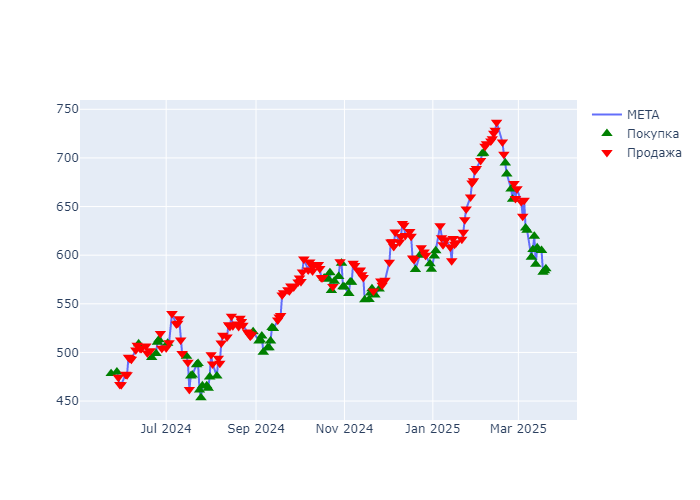

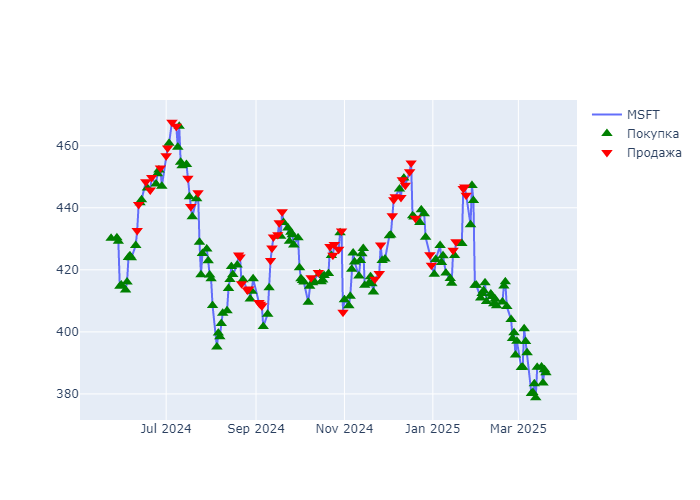

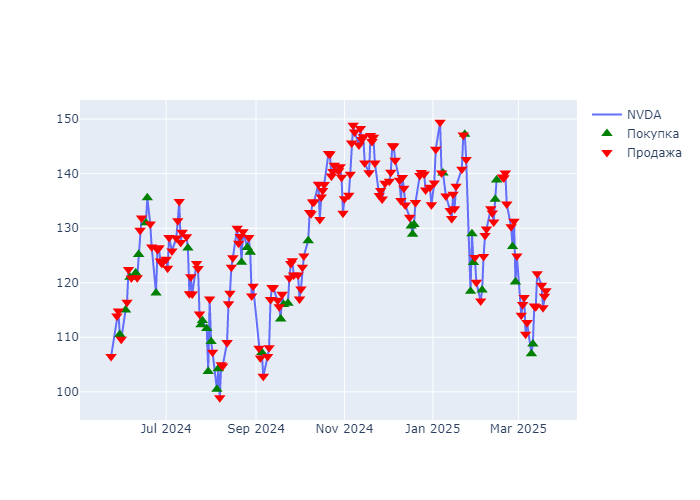

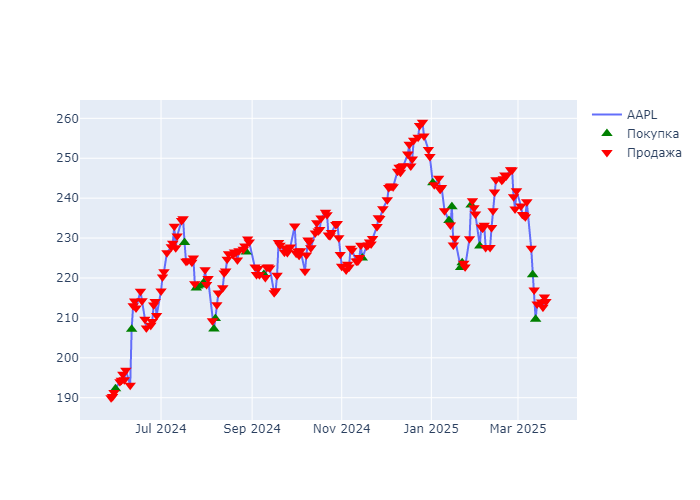

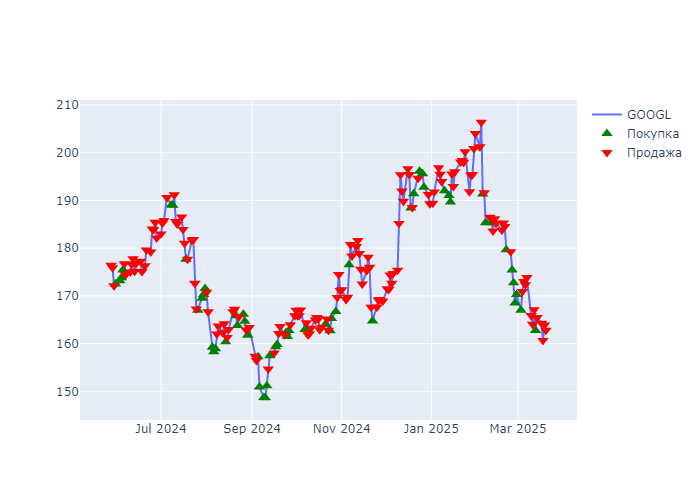

In [21]:
draw_signals(test_df_gb)

### Графики движения акций с установленными сигналами на покупку/продажу по CatBoost

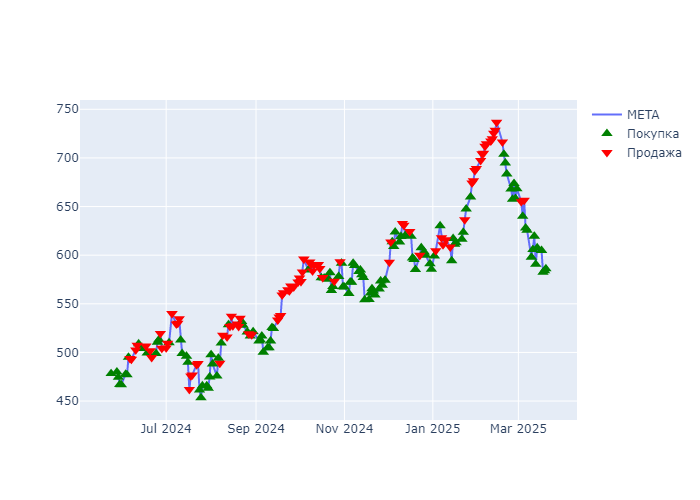

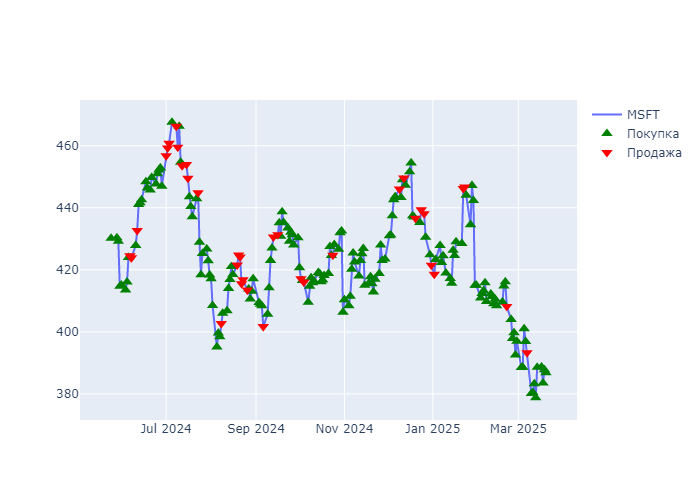

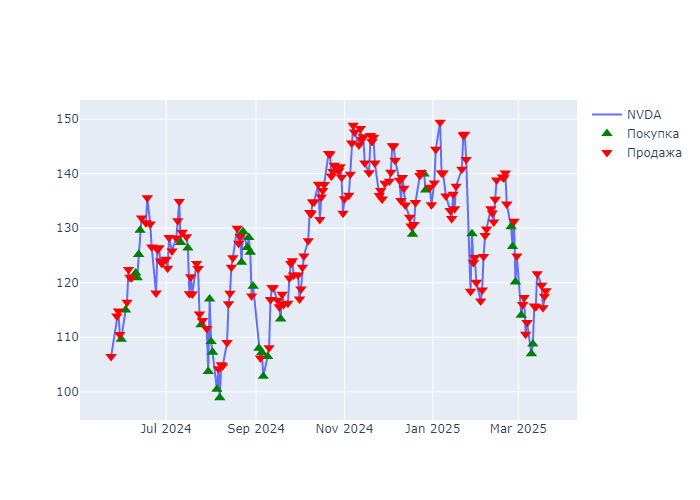

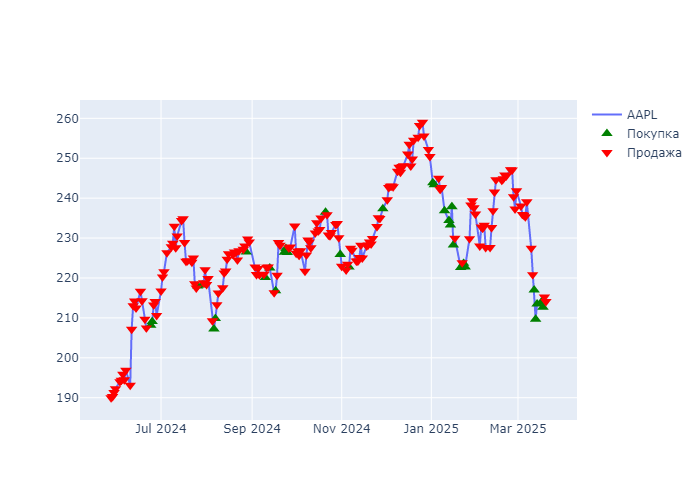

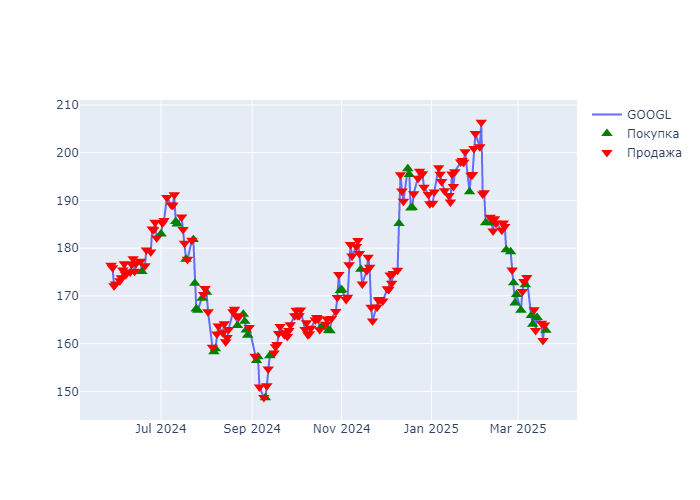

In [22]:
draw_signals(test_df_cb)

## Бэктест

Посмотрим на тестовой выборке, как модели поведут себя и будут ли они прибыльны. Используем библиотеку backtesting

In [17]:
# Добавим столбец где будет указан id трейда
def prepare_data(test_df):
    for ticker in df.tic.unique():
        test_df.loc[test_df['tic'] == ticker,['shift']] = test_df.loc[test_df['tic'] == ticker,'signal'].shift()
        test_df.loc[test_df['tic'] == ticker,['shift']].fillna(0, inplace=True)
        test_df.loc[test_df['tic'] == ticker,['action_x']] =test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'shift'])
        
#        test_df.loc[test_df['tic'] == ticker,['action_id']] = 0
        test_df.loc[test_df['tic'] == ticker,['action_id']] = test_df.loc[test_df['tic'] == ticker,'signal'].ne(test_df.loc[test_df['tic'] == ticker,'signal'].shift()).cumsum()
    return test_df
test_df_gb = prepare_data(test_df_gb)
test_df_cb = prepare_data(test_df_cb)

In [18]:
#Создаем стратегию для покупки / продажи согласно моделям
class ML_strategy(Strategy):
    def init(self):
        # переопределяем Индикатор по колонке Signal
        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]
        if current_signal != self.previous_signal:
            if current_signal == 1:
                if self.position.is_short:
                    self.position.close()

                if not self.position.is_long:
                    self.buy()
            elif current_signal == -1:
                if self.position.is_long:
                    self.position.close()

                if not self.position.is_short:
                    self.sell()
            elif current_signal == 0:
                if self.position:
                    self.position.close()


        self.previous_signal = current_signal
        
# Делаем для каждой модели и акции свой объект класса Backtest
def bt_str(test_df):    
    db_all = pd.DataFrame()
    for ticker in df.tic.unique():  
        # Подготовка данных для бэктестинга
        bt_df = test_df[test_df['tic'] == ticker].copy()
        bt_df.columns = bt_df.columns.str.capitalize()
        bt_df.rename(columns={'Date': 'Datetime'}, inplace=True)
        bt_df["Datetime"] = pd.to_datetime(bt_df["Datetime"])
        bt_df.set_index('Datetime', inplace=True)
        
        # Создаем объект класса Backtest
        bt = Backtest(bt_df, ML_strategy, cash=1_000_000, commission=.002, exclusive_orders=True) # сделки идут последовательно
        
        stats = bt.run()
        
        db_all[ticker] =  stats[:27]
    return db_all
    
#Запускаем    
df_gb = bt_str(test_df_gb)
df_cb = bt_str(test_df_cb)

In [19]:
#Отрисуем результаты
result = pd.concat(
    [df_gb, df_cb],
    axis=1,
    keys=['GradB', 'CatB']
).swaplevel(axis=1).sort_index(axis=1)
result

AAPL                       \
                                       CatB                GradB   
Start                   2024-05-28 00:00:00  2024-05-28 00:00:00   
End                     2025-03-20 00:00:00  2025-03-20 00:00:00   
Duration                  296 days 00:00:00    296 days 00:00:00   
Exposure Time [%]                 24.019608            18.137255   
Equity Final [$]             1058636.546803       1045862.815298   
Equity Peak [$]              1095550.096816       1086396.496834   
Commissions [$]                72016.988293         66683.603068   
Return [%]                         5.863655             4.586282   
Buy & Hold Return [%]             12.690142            12.690142   
Return (Ann.) [%]                  7.292578             5.695625   
Volatility (Ann.) [%]             10.805367             9.493969   
CAGR [%]                           4.970748             3.891456   
Sharpe Ratio                       0.674903              0.59992   
Sortino Ratio                      1.019022             0.877244   
Calmar Ratio                       1.211718             1.119992   
Max. Drawdown [%]                  -6.01838            -5.085416   
Avg. Drawdown [%]                 -1.747705            -2.851632   
Max. Drawdown Duration     64 days 00:00:00    102 days 00:00:00   
Avg. Drawdown Duration     32 days 00:00:00     49 days 00:00:00   
# Trades                                 17                   16   
Win Rate [%]                      70.588235                 75.0   
Best Trade [%]                     3.419905             3.554039   
Worst Trade [%]                   -4.080846            -2.371023   
Avg. Trade [%]                     0.737941             0.682637   
Max. Trade Duration         8 days 00:00:00      6 days 00:00:00   
Avg. Trade Duration         3 days 00:00:00      2 days 00:00:00   
Profit Factor                      3.290062             2.708456   

                                      GOOGL                       \
                                       CatB                GradB   
Start                   2024-05-28 00:00:00  2024-05-28 00:00:00   
End                     2025-03-20 00:00:00  2025-03-20 00:00:00   
Duration                  296 days 00:00:00    296 days 00:00:00   
Exposure Time [%]                 35.294118            41.176471   
Equity Final [$]              859653.957216       1008381.525554   
Equity Peak [$]              1030732.880332       1111568.560166   
Commissions [$]                 98320.96855        114754.992741   
Return [%]                       -14.034604             0.838153   
Buy & Hold Return [%]             -7.709746            -7.709746   
Return (Ann.) [%]                -17.039681             1.036384   
Volatility (Ann.) [%]             13.405669            14.460379   
CAGR [%]                         -12.080266             0.713119   
Sharpe Ratio                       -1.27108             0.071671   
Sortino Ratio                     -1.299284             0.110477   
Calmar Ratio                      -1.026623             0.089587   
Max. Drawdown [%]                -16.597794           -11.568463   
Avg. Drawdown [%]                  -6.03075            -5.171243   
Max. Drawdown Duration    240 days 00:00:00    115 days 00:00:00   
Avg. Drawdown Duration     86 days 00:00:00     56 days 00:00:00   
# Trades                                 26                   28   
Win Rate [%]                           50.0            57.142857   
Best Trade [%]                     5.229077             10.39286   
Worst Trade [%]                   -6.572941            -3.052761   
Avg. Trade [%]                    -0.181527             0.430727   
Max. Trade Duration         7 days 00:00:00      7 days 00:00:00   
Avg. Trade Duration         3 days 00:00:00      3 days 00:00:00   
Profit Factor                      0.839756             1.788431   

                                       META                       \
                         

Вывод: качество моделей оставляют желать лучшего. На каких то акциях лучше отработал GradientBoosting, на каких то CatBoost, но в сумме результат неудовлетворительный. Следующим шагом думаю нужно будет использовать нейронные модели, например RNN и произвести выборку признаков, потому что между ними думаю есть корреляция, лишние убрать. Дальше уже смотреть в сторону ансамблирования.